In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.stats import norm

%load_ext autoreload
%autoreload 2

In [4]:
from football_modelling.data import load_wyscout_match_data

from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())
data_df = load_wyscout_match_data(country="Germany", raw=True)


In [5]:
# Identify the goals and add them to a column
shots = data_df[data_df["subEventName"].isin(["Shot", "Free kick shot", "Penalty"])]


In [6]:
shots = shots.assign(Goal=0)
for i, shot in shots.iterrows():
    for shottags in shot["tags"]:
        # Tags contain that its a goal
        if shottags["id"] == 101:
            shots.at[i, "Goal"] = 1
sum(shots["Goal"])

match_list = shots["matchId"].unique().tolist()
num_matches = len(match_list)
shots_in_match = []
goals_in_match = []
for match in match_list:
    shots_in_match.append(len(shots[shots["matchId"] == match]))
    goals_in_match.append(
        len(shots[np.logical_and(shots["matchId"] == match, (shots["Goal"] == 1))])
    )


In [7]:
shots_in_match


[33,
 24,
 17,
 20,
 32,
 22,
 24,
 19,
 20,
 21,
 30,
 29,
 23,
 18,
 22,
 37,
 18,
 31,
 27,
 17,
 31,
 25,
 21,
 21,
 24,
 26,
 25,
 36,
 26,
 18,
 17,
 26,
 34,
 25,
 27,
 16,
 23,
 16,
 35,
 18,
 23,
 24,
 20,
 37,
 23,
 25,
 24,
 21,
 27,
 29,
 27,
 12,
 20,
 22,
 37,
 25,
 29,
 35,
 23,
 22,
 23,
 23,
 16,
 25,
 21,
 34,
 11,
 29,
 27,
 21,
 21,
 39,
 22,
 30,
 28,
 28,
 16,
 31,
 22,
 25,
 29,
 25,
 32,
 18,
 28,
 19,
 21,
 13,
 22,
 22,
 24,
 27,
 32,
 22,
 29,
 21,
 24,
 22,
 30,
 23,
 18,
 24,
 26,
 19,
 24,
 21,
 26,
 18,
 23,
 23,
 26,
 32,
 29,
 23,
 26,
 29,
 28,
 39,
 20,
 22,
 30,
 26,
 29,
 24,
 26,
 31,
 21,
 25,
 30,
 24,
 17,
 22,
 13,
 22,
 26,
 32,
 18,
 33,
 28,
 22,
 20,
 25,
 28,
 30,
 24,
 27,
 25,
 20,
 21,
 20,
 26,
 35,
 22,
 25,
 22,
 27,
 23,
 14,
 26,
 25,
 34,
 19,
 26,
 27,
 18,
 20,
 33,
 16,
 19,
 28,
 27,
 27,
 15,
 22,
 20,
 22,
 19,
 12,
 21,
 28,
 32,
 19,
 26,
 24,
 23,
 23,
 27,
 26,
 28,
 21,
 14,
 32,
 30,
 25,
 20,
 24,
 25,
 19,
 17,
 21,


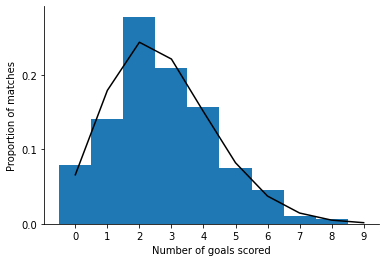

In [8]:
# Set up figure
fig = plt.figure()
from pylab import rcParams

rcParams["figure.figsize"] = 12 / 2.54, 8 / 2.54
ax = fig.add_subplot(1, 1, 1)


# Make histogram of goals/shots
mean_goals = np.mean(goals_in_match)
goals_dist, goals_bins = np.histogram(goals_in_match, bins=np.arange(-0.5, 10.5))
goals_dist = goals_dist / num_matches

# Make Poisson distribution
g = np.arange(0, 10)
Poisson_g = np.zeros(10)
for i, k in enumerate(g):
    Poisson_g[i] = np.power(mean_goals, k) * np.exp(-mean_goals) / np.math.factorial(k)


# Plot data
plt.hist(g - 0.5, 9, weights=goals_dist)
plt.plot(g, Poisson_g, color="black")
ax.set_yticks(np.arange(0, 0.3, 0.1))
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_position("zero")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks(np.arange(0, 10, 1))
ax.set_ylabel("Proportion of matches")
ax.set_xlabel("Number of goals scored")
plt.show()

# Save the figure to a pdf
fig.savefig("output/PoissonDistributionGoals.pdf", dpi=None, bbox_inches="tight")


In [9]:
g = np.arange(0, 10)
for i, k in enumerate(g):
    print(f"{i} {k}")


0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9


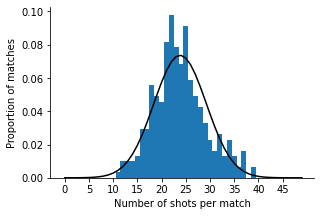

In [25]:
# Set up figure
fig = plt.figure()
from pylab import rcParams

rcParams["figure.figsize"] = 12 / 2.54, 8 / 2.54
ax = fig.add_subplot(1, 1, 1)

# Make histogram of shots
mean_shots = np.mean(shots_in_match)
std_shots = np.std(shots_in_match)
shots_dist, shots_bins = np.histogram(shots_in_match, bins=np.arange(-0.5, 50.5))
shots_dist = shots_dist / num_matches

# Make Poisson distribution
g = np.arange(0, 50)
normal_g = np.zeros(50)
ndist = norm(mean_shots, std_shots)
for i, k in enumerate(g):
    normal_g[i] = ndist.pdf(i)


# Plot data
plt.hist(g - 0.5, 49, weights=shots_dist)
plt.plot(g, normal_g, color="black")
ax.set_yticks(np.arange(0, 0.11, 0.02))
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_position("zero")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks(np.arange(0, 50, 5))
ax.set_ylabel("Proportion of matches")
ax.set_xlabel("Number of shots per match")
plt.show()

# Save the figure to a pdf
fig.savefig("output/PoissonDistributionShots.pdf", dpi=None, bbox_inches="tight")
